The techniques used for in this notebook include:

* Visualization of Important Insights using Matplotlib libraray
* Data Wrangling using Pandas
* Bagging and Boosting Techniques to improve bias and variance
* Cross-Validation and Machine Learning Curves for Model Evaluation
* Stacking: Improvement in bias and Variance by 10%.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/onlinenewspopularity/OnlineNewsPopularity.csv


In [2]:
data=pd.read_csv('/kaggle/input/onlinenewspopularity/OnlineNewsPopularity.csv')

In [3]:
data.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


# ****1. Expolatory Data Analysis (EDA)****

In [4]:
data['url'][2000]

'http://mashable.com/2013/02/10/wedding-proposal-videos/'

In [5]:
import nltk
import re
import string
from datetime import datetime

In [6]:
date=[]
date_original=[]

for i in range(data.shape[0]):
    x=re.findall(r'[0-9]{4}/[0-9]{2}/[0-9]{2}',data['url'][i])
    date.append(x)
    
for i in date:
    for r in i:
        date_original.append(r)

In [7]:
data['date']=date_original

In [8]:
data['date']= pd.to_datetime(data['date'])

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


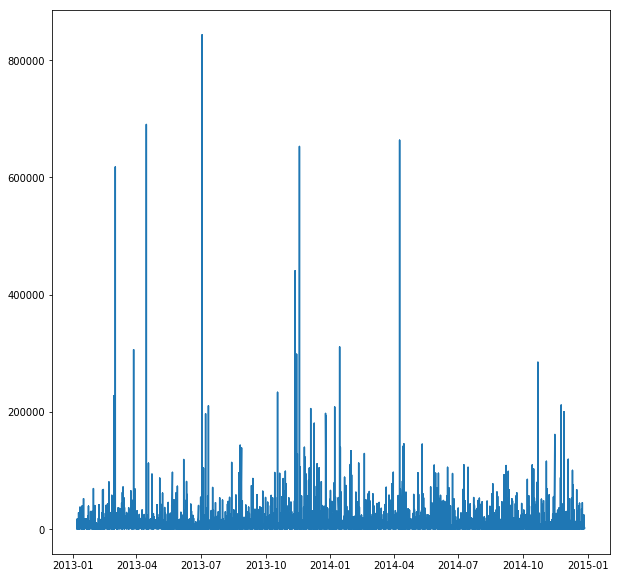

In [9]:
fig=plt.figure(figsize=(10,10))
ax=fig.gca()
plt.plot(data['date'],data[' shares'])
plt.show()

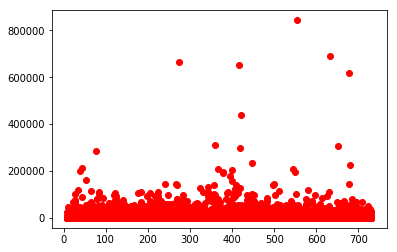

In [10]:
plt.scatter(data[' timedelta'],data[' shares'],c='r')


### Observations:

1) Time Delta (The days between the dataset compilation and article publishing) v Number of shares

2) There are more outliers such as after 400 days more articles have been shared more than 20k times

3) These outliers are not helping to check the exact distribution of data and are skewing the results

In [11]:
data.shape[0]

39644

In [12]:
for i in range(data.shape[0]):
    if data[' shares'][i] > 28000:
        data.drop(index=i,inplace=True)
        

In [13]:
data=data.reset_index(drop=True)

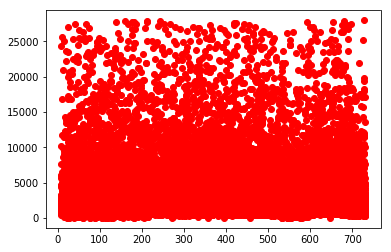

In [14]:
plt.scatter(data[' timedelta'],data[' shares'],c='r')

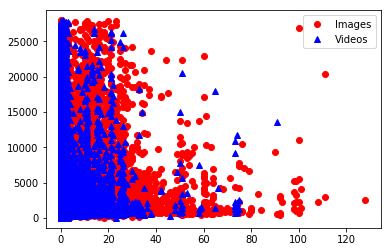

In [15]:
plt.plot(data[' num_imgs'],data[' shares'],'ro',label='Images')
plt.plot(data[' num_videos'],data[' shares'],'b^',label='Videos')
plt.legend()

### This was for getting the relation between number of videos and images in an article with their corresponding shares.

1) If number of videos and images exceeds 80 then shares come close to 0-5k.

2) Most of the articles between 0-40 images and videos has been shared 0-20k times

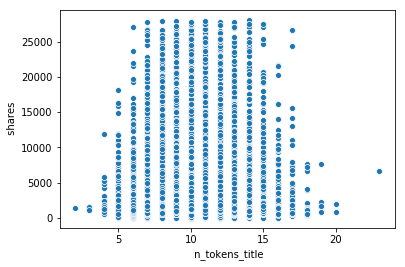

In [16]:
sns.scatterplot(data[' n_tokens_title'],data[' shares'])

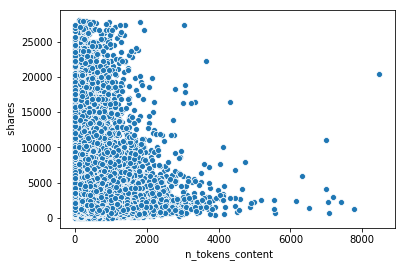

In [17]:
sns.scatterplot(data[' n_tokens_content'],data[' shares'])

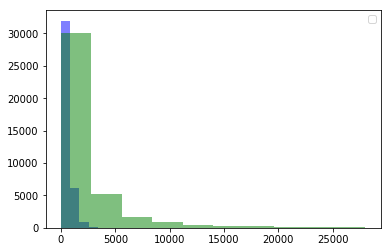

In [24]:
plt.hist(data[' n_tokens_content'],alpha=0.5,color='b')
plt.hist(data[' shares'],alpha=0.5,color='g')
plt.legend()

## Observations:

1) Too short and too long titles are not getting good response. Words between 5-18 are good.

2) Total words between 0-20k are getting the higher response.Above 20k articles have not been shared more than 500 times.

3) Both "shares" and "n_number_tokens" are right skewed.That means data is concentrated in lower half.

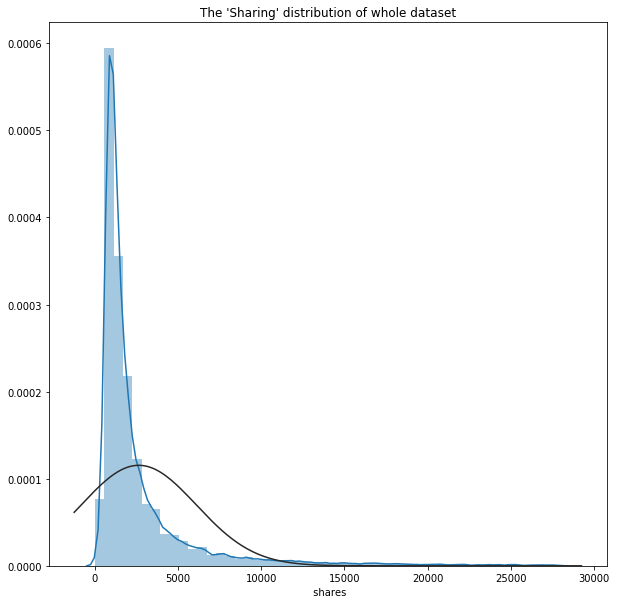

In [25]:
from scipy.stats import norm
fig= plt.figure(figsize=(10,10))
ax=fig.gca()
ax.set_title("The 'Sharing' distribution of whole dataset")
sns.distplot(data[' shares'],ax=ax, fit=norm)


In [26]:
print("Skew:",data[' shares'].skew())

Skew: 3.6009669969582965


A Positive Skew means that data is right skewed and it can be corrected with log or square root.

#### 1. it is positive skewed so more data in lower half.
#### 2. We cannot use squared error term as it would highlight the higher terms with errors so would make results less interpretable.
#### 3. We can power transform the target variable or leave it as it is.

In [35]:
lifestyle_articles=data[data[' data_channel_is_lifestyle'] == 1][' shares'].sum()
entertainment_articles=data[data[' data_channel_is_entertainment'] == 1][' shares'].sum()
business_articles=data[data[' data_channel_is_bus'] == 1][' shares'].sum()
socialmedia_articles=data[data[' data_channel_is_socmed'] == 1][' shares'].sum()
technical_articles=data[data[' data_channel_is_tech'] == 1][' shares'].sum()
world_articles=data[data[' data_channel_is_world'] == 1][' shares'].sum()

<BarContainer object of 6 artists>

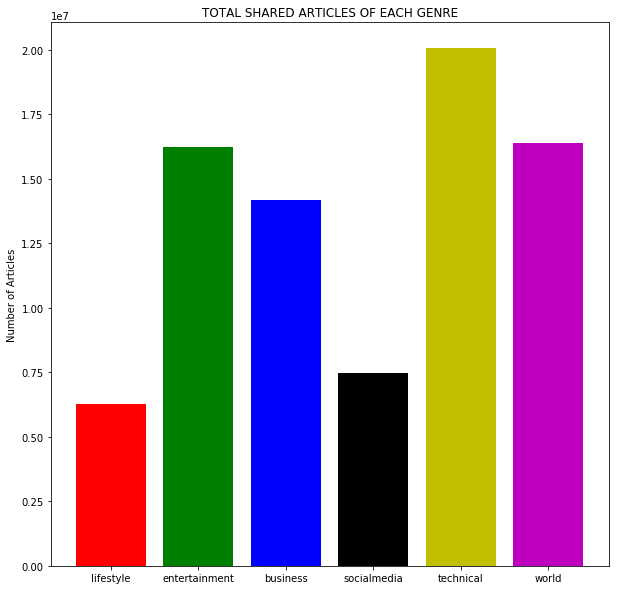

In [38]:
articles_types=np.array([lifestyle_articles,entertainment_articles,business_articles,socialmedia_articles,technical_articles,world_articles],dtype=np.int64)
fig= plt.figure(figsize=(10,10))
ax=fig.gca()
ax.set_title('TOTAL SHARED ARTICLES OF EACH GENRE')
ax.set_ylabel('Number of Articles')
plt.bar(x=['lifestyle','entertainment','business','socialmedia','technical','world'],height=articles_types,color='rgbkymc')


In [29]:
articles_types

array([ 6272279, 16238428, 14180070,  7481357, 20069193, 16379535])

### Observations:

1) Technical genre articles are the highest ones in sharing order.

2) lifestyle articles are shared the least.

In [30]:
monday_articles=data[data[' weekday_is_monday'] == 1][' shares'].sum()
tuesday_articles=data[data[' weekday_is_tuesday'] == 1][' shares'].sum()
wednesday_articles=data[data[' weekday_is_wednesday'] == 1][' shares'].sum()
thursday_articles=data[data[' weekday_is_thursday'] == 1][' shares'].sum()
friday_articles=data[data[' weekday_is_friday'] == 1][' shares'].sum()
saturday_articles=data[data[' weekday_is_saturday'] == 1][' shares'].sum()
sunday_articles=data[data[' weekday_is_sunday'] == 1][' shares'].sum()
weekend_articles=data[data[' is_weekend'] == 1][' shares'].sum()

<BarContainer object of 8 artists>

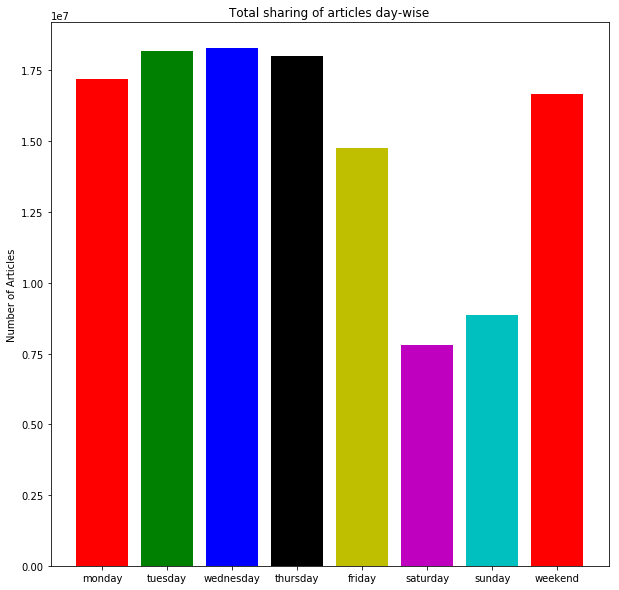

In [39]:
articles_publishing_days= np.array([monday_articles,tuesday_articles,wednesday_articles,thursday_articles,friday_articles,
                                    saturday_articles,sunday_articles,weekend_articles])
fig= plt.figure(figsize=(10,10))
ax=fig.gca()
ax.set_title('Total sharing of articles day-wise')
ax.set_ylabel('Number of Articles')
plt.bar(x=['monday','tuesday','wednesday','thursday','friday','saturday','sunday','weekend'],height=articles_publishing_days
        ,color='rgbkymc')


In [32]:
result=[]
days=[' weekday_is_monday',' weekday_is_tuesday',' weekday_is_wednesday',' weekday_is_thursday',' weekday_is_friday',
     ' weekday_is_saturday',' weekday_is_sunday',' is_weekend']
genre=[' data_channel_is_lifestyle',' data_channel_is_entertainment',' data_channel_is_bus',' data_channel_is_socmed',
       ' data_channel_is_tech',' data_channel_is_world']
for i in days:
    list1=[]
    for j in genre:
        list1.append(data.groupby([i,j])[' shares'].sum()[1][1])
    print('Best channel on {} has articles {} and channel is {}'.format(i,max(list1),genre[list1.index(max(list1))]))

Best channel on  weekday_is_monday has articles 3230332 and channel is  data_channel_is_tech
Best channel on  weekday_is_tuesday has articles 3883646 and channel is  data_channel_is_tech
Best channel on  weekday_is_wednesday has articles 3807165 and channel is  data_channel_is_tech
Best channel on  weekday_is_thursday has articles 3328651 and channel is  data_channel_is_tech
Best channel on  weekday_is_friday has articles 2607854 and channel is  data_channel_is_tech
Best channel on  weekday_is_saturday has articles 1764513 and channel is  data_channel_is_tech
Best channel on  weekday_is_sunday has articles 1770970 and channel is  data_channel_is_entertainment
Best channel on  is_weekend has articles 3211545 and channel is  data_channel_is_tech


In [40]:
Worst_min_shares=pd.DataFrame(data.groupby([' kw_min_min'],sort=True)[' shares'].sum())
Worst_max_shares=pd.DataFrame(data.groupby([' kw_max_min'],sort=True)[' shares'].sum())
Worst_avg_shares=pd.DataFrame(data.groupby([' kw_avg_min'],sort=True)[' shares'].sum())
Best_min_shares=pd.DataFrame(data.groupby([' kw_min_max'],sort=True)[' shares'].sum())
Best_max_shares=pd.DataFrame(data.groupby([' kw_max_max'],sort=True)[' shares'].sum())
Best_avg_shares=pd.DataFrame(data.groupby([' kw_avg_max'],sort=True)[' shares'].sum())
Normal_min_shares=pd.DataFrame(data.groupby([' kw_min_avg'],sort=True)[' shares'].sum())
Normal_max_shares=pd.DataFrame(data.groupby([' kw_max_avg'],sort=True)[' shares'].sum())
Normal_avg_shares=pd.DataFrame(data.groupby([' kw_avg_avg'],sort=True)[' shares'].sum())

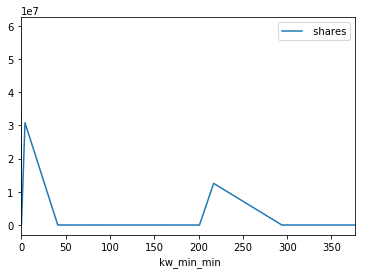

In [41]:
Worst_min_shares.plot()

In [1]:
Lda_00=pd.DataFrame(data.groupby(by=[' LDA_00'])[' shares'].sum().sort_values(ascending=False)).reset_index()
Lda_01=pd.DataFrame(data.groupby(by=[' LDA_01'])[' shares'].sum().sort_values(ascending=False)).reset_index()
Lda_02=pd.DataFrame(data.groupby(by=[' LDA_02'])[' shares'].sum().sort_values(ascending=False)).reset_index()
Lda_03=pd.DataFrame(data.groupby(by=[' LDA_03'])[' shares'].sum().sort_values(ascending=False)).reset_index()
Lda_04=pd.DataFrame(data.groupby(by=[' LDA_04'])[' shares'].sum().sort_values(ascending=False)).reset_index()

NameError: name 'pd' is not defined

In [43]:
## mean respective lda for > 50 shares
mean_lda_00=np.mean(Lda_00[Lda_00[' shares'] > 50])[0]
mean_lda_01=np.mean(Lda_01[Lda_01[' shares'] > 50])[0]
mean_lda_02=np.mean(Lda_02[Lda_02[' shares'] > 50])[0]
mean_lda_03=np.mean(Lda_03[Lda_03[' shares'] > 50])[0]
mean_lda_04=np.mean(Lda_04[Lda_04[' shares'] > 50])[0]

<BarContainer object of 5 artists>

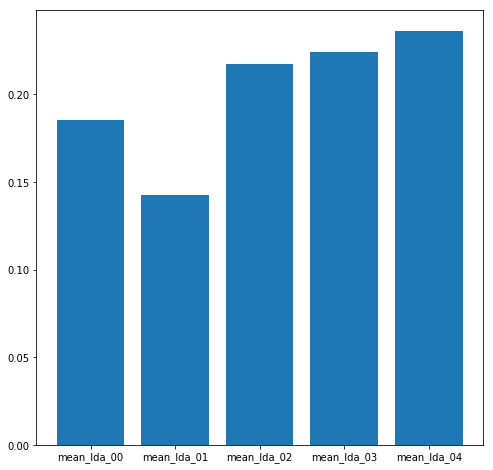

In [44]:
fig=plt.figure(figsize=(8,8))
ax=fig.gca()
plt.bar(x=['mean_lda_00','mean_lda_01','mean_lda_02','mean_lda_03','mean_lda_04'],
        height=[mean_lda_00,mean_lda_01,mean_lda_02,mean_lda_03,mean_lda_04])

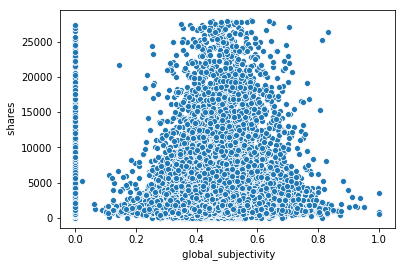

In [45]:
sns.scatterplot(x=data[' global_subjectivity'],y=data[' shares']) # Subjectivity from 0.0-1.0

In [46]:
columns_group_3=[' global_sentiment_polarity', ' global_rate_positive_words',
       ' global_rate_negative_words', ' rate_positive_words',
       ' rate_negative_words', ' avg_positive_polarity',
       ' min_positive_polarity', ' max_positive_polarity',
       ' avg_negative_polarity', ' min_negative_polarity',
       ' max_negative_polarity', ' title_subjectivity',
       ' title_sentiment_polarity', ' abs_title_subjectivity',
       ' abs_title_sentiment_polarity', ' shares']

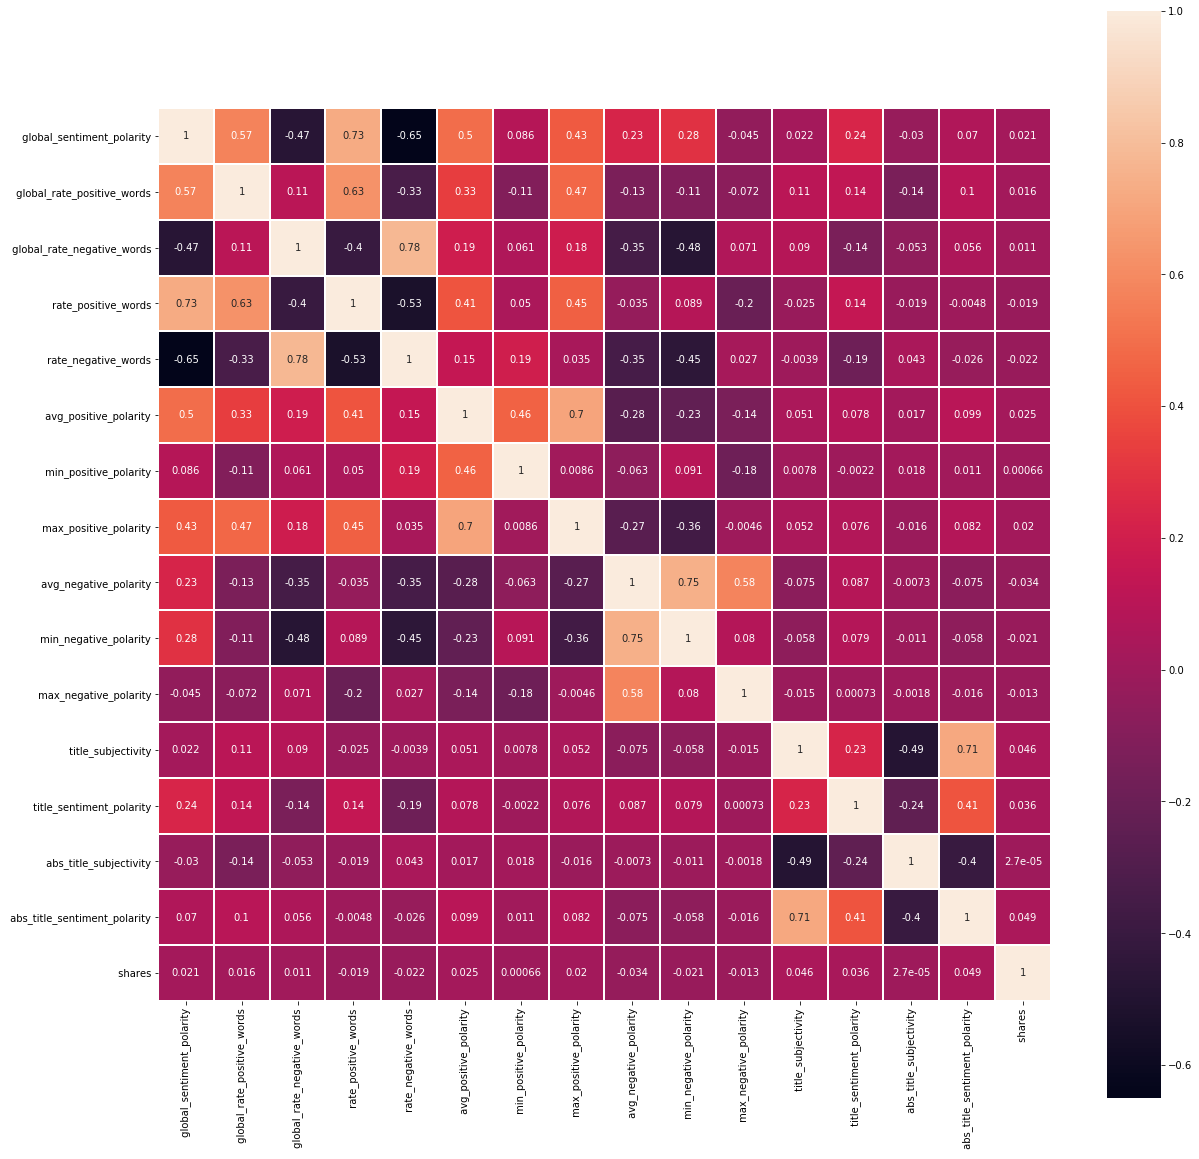

In [47]:
fig, ax = plt.subplots(figsize=(20,20))

sns.heatmap(data[columns_group_3].corr(),linewidth=1.0,ax=ax,square=True,annot=True)

# 2. Principal Component Analysis

In [48]:
from sklearn.decomposition import PCA

In [49]:
y= data[' shares']

In [50]:
pca_data=data.drop(labels=['url',' shares','date'],axis=1)

In [51]:
pca_data.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364


In [52]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
data_transformed= scaler.fit_transform(pca_data)

In [53]:
pca=PCA()
principal_comp=pd.DataFrame(pca.fit_transform(pca_data))

In [54]:
principal_comp.head()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,791021.495428,83404.305658,-4678.168676,-5776.270379,-144.076118,-4092.341275,-102.275303,650.736809,1038.849780,936.544594,...,0.005491,-0.009271,0.005382,0.052455,0.011097,-0.002560,-0.003052,-4.487488e-07,7.007984e-11,1.644919e-10
1,791031.717685,83378.123283,-4483.142243,-6536.584976,-491.641366,-4081.641056,-117.560039,647.114347,1038.175264,952.836909,...,-0.040361,-0.007435,-0.004695,-0.016577,0.024048,0.002821,0.002272,-1.313122e-06,-1.169854e-10,-8.244335e-11
2,791012.797033,83426.566435,-4844.084574,-5129.380620,151.599427,-4101.483712,-89.155679,653.873676,1039.316305,933.230955,...,-0.050266,0.037994,0.067029,-0.045597,-0.040833,-0.015745,0.000572,6.488661e-07,1.939724e-10,-8.838428e-11
3,791031.702526,83377.935742,-4482.973401,-6536.472238,-492.072895,-4082.110141,-116.145104,647.777587,1036.835804,1081.576060,...,0.031495,0.020979,-0.029307,-0.020405,0.002897,0.005661,0.000900,6.731578e-07,-4.395995e-11,-2.689508e-12
4,790836.088810,83897.886679,-8235.468719,7996.887885,-6443.340052,-4532.560234,2124.075318,724.081334,1037.112774,1321.347730,...,-0.064586,0.010790,0.042097,-0.015292,0.000365,0.013418,-0.004283,-6.134374e-07,-6.427848e-11,1.094328e-10


In [55]:
pca.explained_variance_ratio_

array([7.63976554e-01, 1.63195754e-01, 3.52492986e-02, 3.17219496e-02,
       4.84094167e-03, 6.01627888e-04, 2.77247942e-04, 1.12639413e-04,
       1.67201215e-05, 3.46046463e-06, 2.90853352e-06, 5.28805716e-07,
       3.47409938e-07, 1.79607444e-08, 1.46381115e-09, 7.59014860e-10,
       7.15471984e-10, 2.16898393e-10, 1.59100963e-10, 5.90130965e-11,
       3.75327159e-11, 9.35781288e-12, 3.59951878e-12, 3.15248023e-12,
       2.73366160e-12, 2.65784910e-12, 2.63119067e-12, 2.60477714e-12,
       2.42879948e-12, 2.16956337e-12, 2.11278768e-12, 1.19290115e-12,
       1.02603041e-12, 9.27831512e-13, 8.52270783e-13, 7.96517257e-13,
       7.72828491e-13, 6.49858477e-13, 3.80464247e-13, 3.66363498e-13,
       3.44065381e-13, 3.24521033e-13, 2.71216098e-13, 2.30916328e-13,
       1.49117430e-13, 1.12166411e-13, 8.07278714e-14, 6.68598282e-14,
       6.29388154e-14, 3.26726283e-14, 2.16222079e-14, 1.79645290e-14,
       1.20365051e-14, 6.66033423e-15, 1.89505378e-15, 2.20213457e-16,
      

# 3. Model Selection:

# 3(a).Random Forest Regressor

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [57]:
test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(pca_data, y,  
    test_size=test_size,random_state=23)

In [58]:

param_grid= {'n_estimators':[20,40],
            'max_depth':[10,20],
             'max_features':['auto',10,20],
             'bootstrap':[True,False],             
            }

## Initial result gave both extreme values as best parameters so run again by increasing limit

In [59]:
random_search= RandomizedSearchCV(RandomForestRegressor(),param_distributions=param_grid,
                                  cv=5,scoring='neg_mean_absolute_error',
                         verbose=1,n_jobs=-1)
randomsearch_result=random_search.fit(X_train,y_train)
best_paramters= randomsearch_result.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.1min finished


In [60]:
pd.DataFrame(randomsearch_result.cv_results_).sort_values('mean_test_score',ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,5.815596,0.092147,0.039396,0.001053,40,10,10,True,"{'n_estimators': 40, 'max_features': 10, 'max_...",-1935.776324,-1944.238832,-1874.096747,-1896.424904,-1911.582520,-1912.423865,25.624879,1
7,8.492078,0.123533,0.040710,0.000337,40,10,10,False,"{'n_estimators': 40, 'max_features': 10, 'max_...",-1943.233885,-1940.827379,-1881.034535,-1904.243480,-1915.222470,-1916.912350,23.303757,2
5,5.653952,0.172501,0.021401,0.000349,20,20,10,True,"{'n_estimators': 20, 'max_features': 20, 'max_...",-1947.247671,-1950.848381,-1883.624260,-1895.345200,-1925.781395,-1920.569381,27.044095,3
4,16.142001,0.473542,0.100243,0.003762,40,10,20,False,"{'n_estimators': 40, 'max_features': 10, 'max_...",-2001.826895,-2007.926716,-1960.648320,-1976.010983,-1984.680212,-1986.218625,17.177092,4
1,22.648995,3.720015,0.117054,0.044595,40,20,20,True,"{'n_estimators': 40, 'max_features': 20, 'max_...",-2006.064531,-2035.079426,-1970.848304,-1995.995794,-2001.658634,-2001.929338,20.578334,5
9,29.496117,3.190066,0.087300,0.007276,40,20,20,False,"{'n_estimators': 40, 'max_features': 20, 'max_...",-2012.516283,-2036.879998,-1972.687616,-2004.262539,-1992.368317,-2003.742951,21.303151,6
8,7.914309,0.078642,0.051293,0.001305,20,10,20,False,"{'n_estimators': 20, 'max_features': 10, 'max_...",-2023.299222,-2019.459058,-2000.653059,-2009.174231,-2004.399242,-2011.396963,8.671808,7
3,5.120726,0.081363,0.048333,0.001175,20,10,20,True,"{'n_estimators': 20, 'max_features': 10, 'max_...",-2033.726267,-2038.803748,-1981.778711,-2005.473339,-2006.246058,-2013.205625,20.843394,8
2,29.591577,4.818376,0.022726,0.003169,20,auto,10,False,"{'n_estimators': 20, 'max_features': 'auto', '...",-2047.925352,-2058.913871,-2010.583281,-2001.062286,-2010.463583,-2025.789675,23.085787,9
0,51.729282,5.957328,0.039102,0.001109,40,auto,10,False,"{'n_estimators': 40, 'max_features': 'auto', '...",-2047.046471,-2061.406103,-2006.126169,-2005.871625,-2014.911924,-2027.072458,22.864214,10


In [61]:
best_paramters

{'n_estimators': 40, 'max_features': 10, 'max_depth': 10, 'bootstrap': True}

In [62]:
from sklearn.model_selection import cross_val_score
rf=RandomForestRegressor(n_estimators=40,max_depth=10,max_features=10)
scores=cross_val_score(rf,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)

In [63]:
absolute_scores= -scores.mean()

In [64]:
## def display_scores(score):
   ## print("Mean:", score.mean())
   ## print("Standard deviation:", score.std())

In [65]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=10, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [66]:
from sklearn.metrics import mean_absolute_error
y_pred=rf.predict(X_test)
test_score=mean_absolute_error(y_test,y_pred)

In [67]:
test_score

1944.3565517258612

In [68]:
pd.DataFrame({'actual_train_mae_score':absolute_scores,
             'actual_test_mae_score':test_score},index=['Mean'])

### reversing the normalizing of target variable

,actual_train_mae_score,actual_test_mae_score
Mean,1917.978131,1944.356552


In [69]:
df=pd.DataFrame(rf.feature_importances_,pca_data.columns).reset_index()

In [70]:
df.columns=['variables','score']

In [156]:
sorted_df=df.sort_values('score',ascending=False)

In [158]:
important_variables=sorted_df.iloc[1:15,:]

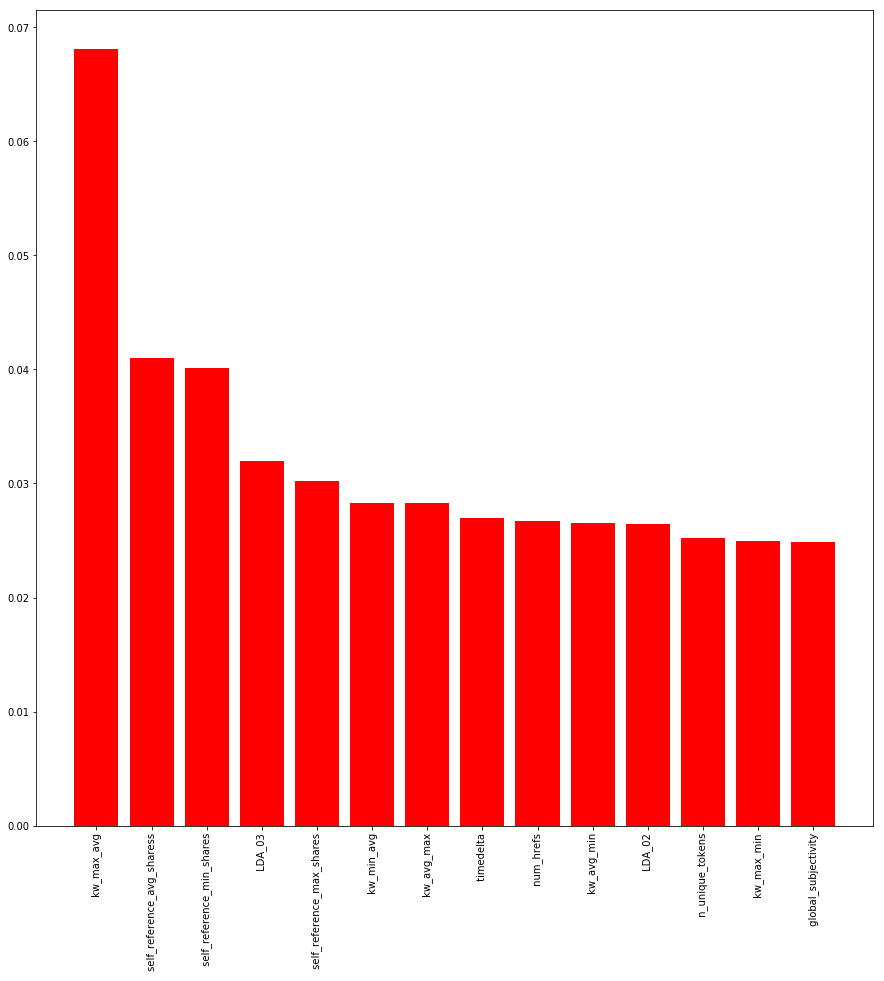

In [162]:
fig=plt.figure(figsize=(15,15))
ax=fig.gca()
plt.bar(x=important_variables.variables,height=important_variables.score,color='r')
plt.xticks(rotation=90)
plt.show()

# 3(b).   RandomForest.PCA__

In [73]:
pca_final_data=principal_comp[[0,1]]

In [74]:
X_train_pca,X_test_pca,y_train_pca,y_test_pca=train_test_split(pca_final_data,y,test_size=0.2,random_state=23)

In [75]:
param_grid_pca= {'n_estimators':[20,40],
            'max_depth':[10,20],
             'bootstrap':[True,False],             
            }

In [76]:
random_search_pca= RandomizedSearchCV(RandomForestRegressor(),param_distributions=param_grid_pca,
                                  cv=5,scoring='neg_mean_absolute_error',
                                  verbose=1,n_jobs=-1)
randomsearch_result_pca=random_search_pca.fit(X_train_pca,y_train_pca)
best_paramters_pca= randomsearch_result_pca.best_params_

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   33.6s finished


In [77]:
pd.DataFrame(randomsearch_result_pca.cv_results_).sort_values('mean_test_score',ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,2.370865,0.013772,0.029958,0.001390,40,10,True,"{'n_estimators': 40, 'max_depth': 10, 'bootstr...",-2067.454177,-2054.769830,-2001.312722,-2017.238719,-2056.102169,-2039.375523,25.471518,1
0,1.181632,0.016947,0.016282,0.000463,20,10,True,"{'n_estimators': 20, 'max_depth': 10, 'bootstr...",-2067.315105,-2062.852015,-2005.583040,-2015.420991,-2057.078913,-2041.650013,25.826579,2
5,3.678126,0.109839,0.028786,0.001164,40,10,False,"{'n_estimators': 40, 'max_depth': 10, 'bootstr...",-2098.675108,-2086.508778,-2066.116651,-2063.259876,-2109.033966,-2084.718876,17.864687,3
4,1.811456,0.017749,0.015643,0.000691,20,10,False,"{'n_estimators': 20, 'max_depth': 10, 'bootstr...",-2097.851207,-2087.245433,-2067.761988,-2062.863086,-2109.768908,-2085.098125,17.724774,4
3,4.129092,0.041929,0.062987,0.000918,40,20,True,"{'n_estimators': 40, 'max_depth': 20, 'bootstr...",-2125.259739,-2118.566176,-2080.553753,-2083.748034,-2107.595303,-2103.144601,18.073662,5
2,2.057995,0.029585,0.033363,0.000814,20,20,True,"{'n_estimators': 20, 'max_depth': 20, 'bootstr...",-2131.974526,-2128.545961,-2079.312686,-2100.339796,-2124.571312,-2112.948856,20.152953,6
7,6.189789,0.625470,0.064311,0.009640,40,20,False,"{'n_estimators': 40, 'max_depth': 20, 'bootstr...",-2298.053572,-2347.568791,-2321.768628,-2257.297554,-2323.147113,-2309.567131,30.469950,7
6,3.249658,0.074030,0.035944,0.002416,20,20,False,"{'n_estimators': 20, 'max_depth': 20, 'bootstr...",-2293.222946,-2349.935077,-2326.464924,-2256.875223,-2322.802961,-2309.860226,32.041953,8


In [78]:
best_paramters_pca

{'n_estimators': 40, 'max_depth': 10, 'bootstrap': True}

In [79]:
rf_pca=RandomForestRegressor(n_estimators=20,max_depth=10)

In [80]:
scores_1=cross_val_score(rf_pca,X_train_pca,y_train_pca,scoring='neg_mean_absolute_error',cv=10)

In [81]:
absolute_scores_1=-scores_1.mean()

In [82]:

rf_pca.fit(X_train_pca,y_train_pca)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [83]:
y_predict_pca= rf_pca.predict(X_test_pca)
test_score_pca= mean_absolute_error(y_test_pca,y_predict_pca)

In [84]:
pd.DataFrame({'train_mse_score':[absolute_scores_1],
             'test_mse_score':[test_score_pca]},index=['Mean'])

,train_mse_score,test_mse_score
Mean,2038.648742,2068.501312


__1(d). Learning Curves__

In [85]:
X_train.shape[0]

31340

In [86]:
train_sizes=[500,800,1000,1250,2500,5000,10000,12000,16000,18000,20000]

In [87]:
from sklearn.model_selection import learning_curve
train_sizes,train_scores,validation_scores= learning_curve(rf,X=X_train,y=y_train,train_sizes=train_sizes,
                                             cv=3,scoring='neg_mean_absolute_error')

In [88]:
train_scores_mean= -train_scores.mean(axis=1)
validation_scores_mean=-validation_scores.mean(axis=1)

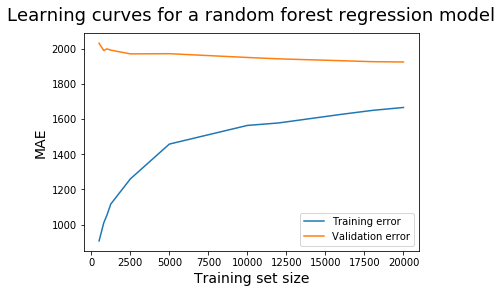

In [89]:
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MAE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a random forest regression model', fontsize = 18, y = 1.03)
plt.legend()

In [90]:
train_sizes,train_scores_pca,validation_scores_pca= learning_curve(rf_pca,X=X_train_pca,y=y_train_pca,train_sizes=train_sizes,
                                             cv=3,scoring='neg_mean_absolute_error')

In [91]:
train_scores_mean_pca= -train_scores_pca.mean(axis=1)
validation_scores_mean_pca=-validation_scores_pca.mean(axis=1)

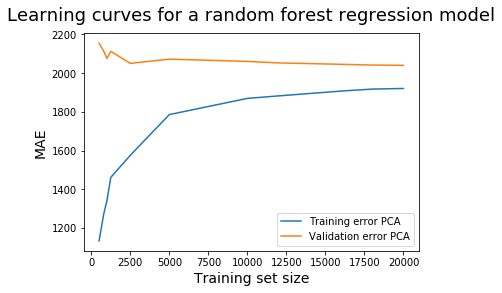

In [92]:
plt.plot(train_sizes, train_scores_mean_pca, label = 'Training error PCA')
plt.plot(train_sizes, validation_scores_mean_pca, label = 'Validation error PCA')
plt.ylabel('MAE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a random forest regression model', fontsize = 18, y = 1.03)
plt.legend()

One solution at this point is to change to a more complex learning algorithm. This should decrease the bias and increase the variance. A mistake would be to try to increase the number of training instances. Generally, these other two fixes also work when dealing with a high bias and low variance problem:

__1. Training the current learning algorithm on more features (to avoid collecting new data, you can generate easily polynomial features). This should lower the bias by increasing the model’s complexity.__

__2. Decreasing the regularization of the current learning algorithm, if that’s the case. In a nutshell, regularization prevents the algorithm from fitting the training data too well. If we decrease regularization, the model will fit training data better, and, as a consequence, the variance will increase and the bias will decrease.__

### Comparison:

1. PCA Model has less variance but more bias------Solution: Train on more features increasing the complexity of model and decreasing the regularization of model.Meaning allowing it to overfit.



2. Normal Model has less bias (as compared to PCA but more than a random forest should have) and more variance.

#### Since it is a bagging method it has less variance. Now we can use boosting to get less bias.

#  3(C). Gradient Boosting

In [93]:
from sklearn.ensemble import GradientBoostingRegressor

In [94]:
param_gradboost={'n_estimators':[100,150],
                'max_depth':[5,10],
                'learning_rate':[0.1,0.2]}

In [138]:
pca_data_gbr= principal_comp[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]]
X_train_gbr,X_test_gbr,y_train_gbr,y_test_gbr=train_test_split(pca_data_gbr,y,test_size=0.2,random_state=23)

In [96]:
grad_randomsearch= RandomizedSearchCV(GradientBoostingRegressor(),param_distributions=param_gradboost,cv=3,
                                      scoring='neg_mean_absolute_error',n_jobs=-1,verbose=1)
grad_fit=grad_randomsearch.fit(X_train_gbr,y_train_gbr)
best_param_grad= grad_fit.best_params_

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  5.9min finished


In [97]:
pd.DataFrame(grad_fit.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,30.906005,0.210952,0.033962,0.000272,100,5,0.1,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",-1948.019416,-1919.546418,-1948.151723,-1938.572519,13.453593,1
1,45.917402,0.145704,0.046511,0.000162,150,5,0.1,"{'n_estimators': 150, 'max_depth': 5, 'learnin...",-1957.578592,-1923.530655,-1957.508181,-1946.205809,16.033781,2
2,58.178459,0.543939,0.065587,0.000534,100,10,0.1,"{'n_estimators': 100, 'max_depth': 10, 'learni...",-2021.712874,-1990.485145,-2019.983662,-2010.727227,14.330712,5
3,87.811828,0.377487,0.092468,0.000670,150,10,0.1,"{'n_estimators': 150, 'max_depth': 10, 'learni...",-2044.074918,-2014.194757,-2028.739622,-2029.003099,12.199947,6
4,30.692358,0.334200,0.031687,0.000159,100,5,0.2,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",-1976.608228,-1935.687932,-1972.554295,-1961.616818,18.409037,3
5,45.689353,0.222164,0.045122,0.000425,150,5,0.2,"{'n_estimators': 150, 'max_depth': 5, 'learnin...",-1989.130808,-1950.722266,-1988.623615,-1976.158896,17.987605,4
6,58.960728,0.117328,0.062023,0.001236,100,10,0.2,"{'n_estimators': 100, 'max_depth': 10, 'learni...",-2101.102859,-2070.701741,-2066.829388,-2079.544663,15.325701,7
7,79.208220,4.745399,0.087679,0.012483,150,10,0.2,"{'n_estimators': 150, 'max_depth': 10, 'learni...",-2115.174654,-2094.318947,-2111.336908,-2106.943503,9.063356,8


In [98]:
best_param_grad

{'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}

In [139]:
gbr= GradientBoostingRegressor(n_estimators=50,max_depth=5,learning_rate=0.1)

In [140]:
grad_result= gbr.fit(X_train_gbr,y_train_gbr)

In [101]:
scores_boosting= cross_val_score(gbr,X_train_gbr,y_train_gbr,scoring='neg_mean_absolute_error',cv=5)

In [102]:
absolute_scores_boosting= - scores_boosting.mean()

In [103]:
y_pred_gbr=gbr.predict(X_test_gbr)
test_score_gbr= mean_absolute_error(y_test_gbr,y_pred_gbr)

In [104]:
pd.DataFrame({'train_mae_score':[absolute_scores_boosting],
             'test_mae_score':[test_score_gbr]},index=['Mean'])

,train_mae_score,test_mae_score
Mean,1928.327178,1952.796372


In [105]:
train_sizes,train_scores_gbr,validation_scores_gbr= learning_curve(gbr,X=X_train_pca,y=y_train_pca,train_sizes=train_sizes,
                                             cv=5,scoring='neg_mean_absolute_error')

In [106]:
train_scores_mean_gbr= -train_scores_gbr.mean(axis=1)
validation_scores_mean_gbr=-validation_scores_gbr.mean(axis=1)

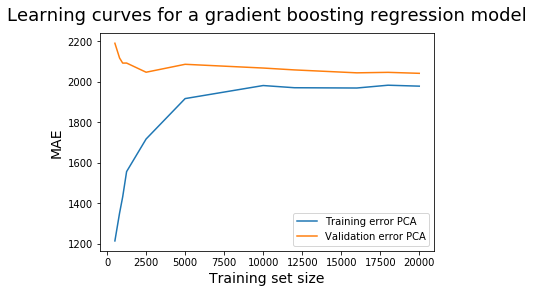

In [107]:
plt.plot(train_sizes, train_scores_mean_gbr, label = 'Training error PCA')
plt.plot(train_sizes, validation_scores_mean_gbr, label = 'Validation error PCA')
plt.ylabel('MAE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a gradient boosting regression model', fontsize = 18, y = 1.03)
plt.legend()

#### This model has much is better than above two in bias and variance.

# 3(d) Gradient Boosting with feature selection

In [134]:
gbr_original=gbr.fit(X_train,y_train)

In [109]:
df_1=pd.DataFrame(X_train.columns,gbr_original.feature_importances_).reset_index()
df_1.columns=['score','variables']
select_columns=df_1.sort_values('score',ascending=False)['variables']

In [136]:
feature_importance_df= pd.concat(objs=[df,df_1],axis=1)
feature_importance_df

,variables,score,score,variables
0,timedelta,0.026938,0.039237,timedelta
1,n_tokens_title,0.012977,0.006640,n_tokens_title
2,n_tokens_content,0.023512,0.025075,n_tokens_content
3,n_unique_tokens,0.025196,0.024367,n_unique_tokens
4,n_non_stop_words,0.000271,0.000000,n_non_stop_words
5,n_non_stop_unique_tokens,0.024702,0.020405,n_non_stop_unique_tokens
6,num_hrefs,0.026674,0.033185,num_hrefs
7,num_self_hrefs,0.012276,0.013481,num_self_hrefs
8,num_imgs,0.016455,0.020588,num_imgs
9,num_videos,0.009258,0.019524,num_videos


In [111]:
feature_importance_df.columns=['Variables_rf','Score_rf','score_gb','Variables_gb']
feature_importance_df=feature_importance_df.sort_values('Score_rf',ascending=False).reset_index(drop=True)

In [112]:
np.sum(feature_importance_df['score_gb'][0:25])

0.813927088739073

In [113]:
select_columns=df_1.sort_values('score',ascending=False)['variables'][0:25]

In [114]:
X_train_select,X_test_select,y_train_select,y_test_select=train_test_split(data[select_columns.reset_index()['variables']],
                                                                           y,test_size=0.2,random_state=23)

In [115]:
grad_randomsearch_select= RandomizedSearchCV(GradientBoostingRegressor(),param_distributions=param_gradboost,cv=3,
                                      scoring='neg_mean_absolute_error',n_jobs=-1,verbose=1)
grad_fit_select=grad_randomsearch_select.fit(X_train_select,y_train_select)
best_param_grad_select= grad_fit_select.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  6.6min finished


In [116]:
pd.DataFrame(grad_fit_select.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,33.490398,0.169927,0.041629,0.002988,100,5,0.1,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",-1928.009316,-1901.167848,-1907.082429,-1912.086531,11.515117,1
1,50.370753,0.196524,0.052145,0.001182,150,5,0.1,"{'n_estimators': 150, 'max_depth': 5, 'learnin...",-1931.744091,-1906.871909,-1912.816715,-1917.144238,10.605091,2
2,64.933586,0.126905,0.076125,0.006625,100,10,0.1,"{'n_estimators': 100, 'max_depth': 10, 'learni...",-2014.210778,-1986.572479,-2017.798858,-2006.194038,13.951649,5
3,97.777433,0.228197,0.106105,0.001539,150,10,0.1,"{'n_estimators': 150, 'max_depth': 10, 'learni...",-2038.158346,-2010.618416,-2036.429087,-2028.401950,12.594658,6
4,33.452077,0.407724,0.035615,0.000982,100,5,0.2,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",-1961.601791,-1923.484986,-1934.711803,-1939.932860,15.993067,3
5,50.384850,0.138017,0.048939,0.000592,150,5,0.2,"{'n_estimators': 150, 'max_depth': 5, 'learnin...",-1980.547654,-1949.743272,-1953.131706,-1961.140877,13.792210,4
6,65.128886,0.159579,0.070471,0.001508,100,10,0.2,"{'n_estimators': 100, 'max_depth': 10, 'learni...",-2106.017054,-2064.545185,-2083.578449,-2084.713562,16.949835,7
7,87.674157,6.088814,0.081326,0.000714,150,10,0.2,"{'n_estimators': 150, 'max_depth': 10, 'learni...",-2114.620605,-2078.294417,-2107.312047,-2100.075690,15.688034,8


In [117]:
best_param_grad_select

{'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}

In [118]:
gbr_select= GradientBoostingRegressor(n_estimators=100,max_depth=5,learning_rate=0.1)

In [119]:
grad_result_select= gbr_select.fit(X_train_select,y_train_select)

In [120]:
scores_boosting_select= cross_val_score(gbr_select,X_train_select,y_train_select,scoring='neg_mean_absolute_error',cv=5)

In [121]:
absolute_scores_boosting_select= - scores_boosting_select.mean()

In [122]:
y_pred_gbr_select=gbr_select.predict(X_test_select)
test_score_gbr_select= mean_absolute_error(y_test_select,y_pred_gbr_select)

In [123]:
pd.DataFrame({'train_mae_score':[absolute_scores_boosting_select],
             'test_mae_score':[test_score_gbr_select]},index=['Mean'])

,train_mae_score,test_mae_score
Mean,1905.996784,1933.00814


In [124]:
train_sizes,train_scores_select,validation_scores_select= learning_curve(gbr_select,X=X_train_select,
                                                                         y=y_train_select,train_sizes=train_sizes,
                                                                           cv=5,scoring='neg_mean_absolute_error')

In [125]:
train_scores_mean_select= -train_scores_select.mean(axis=1)
validation_scores_mean_select=-validation_scores_select.mean(axis=1)

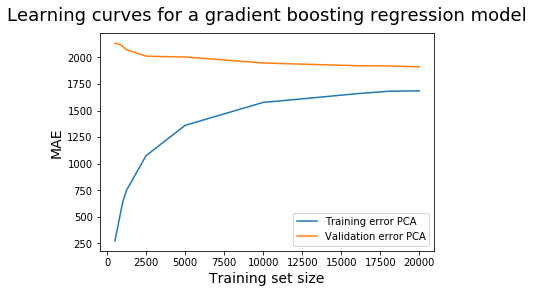

In [126]:
plt.plot(train_sizes, train_scores_mean_select, label = 'Training error PCA')
plt.plot(train_sizes, validation_scores_mean_select, label = 'Validation error PCA')
plt.ylabel('MAE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a gradient boosting regression model', fontsize = 18, y = 1.03)
plt.legend()

### Comparison of all Scores and Models:

In [127]:
Comparison_df= pd.DataFrame({'Training_Scores':[absolute_scores,absolute_scores_1,
                                                absolute_scores_boosting,absolute_scores_boosting_select],
                            'Test_Scores':[test_score,test_score_pca,test_score_gbr,test_score_gbr_select]},
                            index=['Rf','Rf_PCA','gbr','gbr_select'])

In [128]:
Comparison_df['Variance']=np.subtract(Comparison_df['Training_Scores'],Comparison_df['Test_Scores'])

In [129]:
Comparison_df=Comparison_df.sort_values('Training_Scores')

In [130]:
Comparison_df

,Training_Scores,Test_Scores,Variance
gbr_select,1905.996784,1933.008140,-27.011356
Rf,1917.978131,1944.356552,-26.378421
gbr,1928.327178,1952.796372,-24.469194
Rf_PCA,2038.648742,2068.501312,-29.852569


# 3(e). Stacking

From above comaprison, we are going to create a new dataset through predictions of the four models.

In [131]:
data.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,date
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,2013-01-07
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,2013-01-07
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,2013-01-07
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,2013-01-07
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,2013-01-07


In [141]:
X1= rf.predict(pca_data)
X2=rf_pca.predict(pca_final_data)
X3=gbr.predict(pca_data_gbr)
X4=gbr_select.predict(data[select_columns.reset_index()['variables']])

### __To Train the final model on large datasets we had to use whole datasets for prediction here___

In [142]:
data_stacking= pd.DataFrame({'Random_Forest':X1,
                            'Random_Forest_PCA':X2,
                            'GBR':X3,
                            "GBR_select":X4,
                            "Target":y})
data_stacking.head()

,Random_Forest,Random_Forest_PCA,GBR,GBR_select,Target
0,1801.098048,1644.971911,1738.677713,1663.071099,593
1,1826.305596,1387.088422,1738.677713,1893.708101,711
2,1938.152612,1460.529798,1757.019725,1578.719413,1500
3,1968.769121,1460.722019,1686.774698,1710.320977,1200
4,2012.856408,1724.354072,2291.999102,2593.234561,505


In [143]:
from sklearn.linear_model import LinearRegression

In [144]:
X_train_stack,X_test_stack,y_train_stack,y_test_stack= train_test_split(
    data_stacking[['Random_Forest','Random_Forest_PCA','GBR','GBR_select']],y,test_size=0.2)

In [145]:
lr=LinearRegression()
lr.fit(X_train_stack,y_train_stack)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [146]:
training_score_lr= cross_val_score(lr,X_train_stack,y_train_stack,scoring='neg_mean_absolute_error',cv=20)
absolute_training_lr= -training_score_lr.mean()

In [147]:
y_predict_lr= lr.predict(X_test_stack)
test_score_lr= mean_absolute_error(y_test_stack,y_predict_lr)

In [148]:
train_sizes,train_scores_lr,validation_scores_lr= learning_curve(lr,X=X_train_stack,
                                                                         y=y_train_stack,train_sizes=train_sizes,
                                                                           cv=10,scoring='neg_mean_absolute_error')

In [149]:
train_scores_mean_lr= -train_scores_lr.mean(axis=1)
validation_scores_mean_lr=-validation_scores_lr.mean(axis=1)

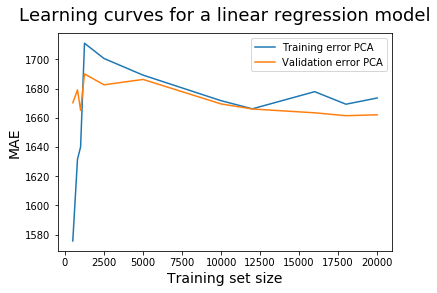

In [150]:
plt.plot(train_sizes, train_scores_mean_lr, label = 'Training error PCA')
plt.plot(train_sizes, validation_scores_mean_lr, label = 'Validation error PCA')
plt.ylabel('MAE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

# Summary:

1. First data is explored using data manipulation techniques of Pandas using visualization techniques by matplotlib package

2. After that, since there are 52 features, Principal Component Analysis(PCA) was done for dimensionality reduction.

3. The first algorithm used is Random Forest Regressor of Sklearn library. It's feature importance was also collected.

4. Secondly same algorithm was used on PCA data which resulted in more bias but less variance.

5. Gradient Boosting Regressor was then used to decrease bias. Here PCA dataset was used as it has less variance originally.

6. Then important features of randomforest were put into Gradient Boosting which proved to be best model of all the four models.

7. During all models, parameters were chosen using Randomized CV and training scores were gathered using cross validation.

8. Finally Stacking of all four models was done. The upper most algorithm was linear regression which proved to be the most effective modelm